In [38]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import torch
from torch import nn
from scipy import stats

# Random

In [39]:
class RandomSampler():
    name = "random"

    def select_batch(self, X_unlab, batch_size, **kwargs):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))
        
        unlab_inds = np.arange(X_unlab.shape[0])
        return np.random.choice(unlab_inds, size=batch_size, replace=False)

    def get_weights(self, X_unlab, **kwargs):
        return np.ones(len(X_unlab))

# Uncertainty Samplers

## 1. Least Confident

In [40]:
class LeastConfidentSampler():
    name = "least_confident"

    def select_batch(self, X_unlab, batch_size, model, multilabel, **kwargs):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        probs = model.predict_proba(X_unlab)
        max_probs = self.get_weights(probs, multilabel)

        # Retrieve `batch_size` instances with lowest posterior probabilities.
        top_n = np.argpartition(max_probs, batch_size)[:batch_size]
        return top_n

    def get_weights(self, probs, multilabel, **kwargs):
        if multilabel:
            max_binary_probs = np.where(probs > 0.5, probs, 1 - probs)
            max_probs = np.prod(max_binary_probs, axis=1)
        else:
            max_probs = np.max(probs, axis=1)

        scaler = MinMaxScaler()
        max_probs = scaler.fit_transform(max_probs.reshape(-1, 1)).reshape(-1)
        return max_probs

## 2. Margin

In [41]:
class MarginSampler():
    name = "margin"

    def select_batch(self, X_unlab, batch_size, model, multilabel, **kwargs):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        if not multilabel and hasattr(model, "decision_function"):
            probs = model.decision_function(X_unlab)
        else:
            # the model doesn't have decision_function implemented, work with probabilities
            probs = model.predict_proba(X_unlab)
        min_margin = self.get_weights(probs, multilabel)

        # Retrieve `batch_size` instances with smallest margins.
        top_n = np.argpartition(min_margin, batch_size)[:batch_size]
        return top_n

    def get_weights(self, probs, multilabel, **kwargs):
        if multilabel:
            max_binary_probs = np.where(probs > 0.5, probs, 1 - probs)
            second_max_binary_probs = np.copy(max_binary_probs)
            # Take 1-p of the smallest probability in each row
            second_max_binary_probs[
                np.arange(second_max_binary_probs.shape[0]),
                np.argmin(second_max_binary_probs, axis=1),
            ] = (
                1
                - second_max_binary_probs[
                    np.arange(second_max_binary_probs.shape[0]),
                    np.argmin(second_max_binary_probs, axis=1),
                ]
            )
            max_probs = np.prod(max_binary_probs, axis=1)
            second_max_probs = np.prod(second_max_binary_probs, axis=1)
            min_margin = max_probs - second_max_probs
        else:
            if len(probs.shape) == 1:
                # If decision_function was used and task is binary
                min_margin = abs(probs)
            else:
                sort_probs = np.sort(probs, 1)[:, -2:]
                min_margin = sort_probs[:, 1] - sort_probs[:, 0]

        scaler = MinMaxScaler()
        min_margin = scaler.fit_transform(min_margin.reshape(-1, 1)).reshape(-1)
        return min_margin

## 3. Entropy

In [42]:
class EntropySampler():
    name = "entropy"

    def select_batch(self, X_unlab, batch_size, model, multilabel, **kwargs):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        probs = model.predict_proba(X_unlab)

        entropies = self.get_weights(probs, multilabel)

        # Retrieve `batch_size` instances with lowest negative entropies.
        top_n = np.argpartition(entropies, batch_size)[:batch_size]
        return top_n

    def get_weights(self, probs, multilabel, **kwargs):
        # Clip for numerical stability.
        probs = np.clip(probs, a_min=1e-6, a_max=1 - 1e-6)
        if multilabel:
            binary_entropies = -probs * np.log(probs) - (1 - probs) * np.log(1 - probs)
            entropies = np.sum(binary_entropies, axis=1)
        else:
            entropies = np.sum(-probs * np.log(probs), axis=1)

        # We are selecting batch with argmin
        entropies = -entropies
        scaler = MinMaxScaler()
        entropies = scaler.fit_transform(entropies.reshape(-1, 1)).reshape(-1)
        return entropies

## 4. Multi-Label Uncertainty Sampler

In [43]:
class MultilabelUncertaintySampler():
    name = "multilabel_uncertainty"

    def select_batch(self, X_unlab, batch_size, model, **kwargs):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        probs = model.predict_proba(X_unlab)
        min_margin = self.get_weights(probs)
        top_n = np.argpartition(min_margin, batch_size)[:batch_size]
        return top_n

    def get_weights(self, probs, **kwargs):
        min_margin = np.sum(abs(probs - 0.5), axis=1)
        scaler = MinMaxScaler()
        min_margin = scaler.fit_transform(min_margin.reshape(-1, 1)).reshape(-1)
        return min_margin

# Density Samplers

## 1. Density

In [44]:
distance_types = {"cos": cosine_distances, "euclid": euclidean_distances}


class DensitySampler():
    name = "density"

    def select_batch(self, X_unlab, batch_size, distance="cos", **kwargs):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        avg_distance = self.get_weights(X_unlab, distance)

        # Retrieve `batch_size` instances with lowest average distance.
        top_n = np.argpartition(avg_distance, batch_size)[:batch_size]
        return top_n

    def get_weights(self, X_unlab, distance="cos", **kwargs):
        if isinstance(distance, str):
            try:
                distance = distance_types[distance]
            except KeyError:
                raise ValueError("Distance %s not supported" % (distance))

        # Working with distance instead of similarity, because argmin is used to create batch
        distance_matrix = distance(X_unlab)
        avg_distance = np.sum(distance_matrix, axis=1) / (len(X_unlab) - 1)

        scaler = MinMaxScaler()
        avg_distance = scaler.fit_transform(avg_distance.reshape(-1, 1)).reshape(-1)
        return avg_distance

# Combined Samplers

## 1. Adjustable Combined Sampler

In [45]:
class CombinedSampler():
    name = "combined"

    def select_batch(
        self,
        X_unlab,
        samplers,
        batch_size,
        powers=None,
        model=None,
        multilabel=None,
        **kwargs,
    ):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        if model:
            probs = model.predict_proba(X_unlab)
        else:
            probs = None
        final_weights = self.get_weights(
            samplers=samplers,
            powers=powers,
            probs=probs,
            X_unlab=X_unlab,
            multilabel=multilabel,
            **kwargs,
        )

        # Retrieve `batch_size` instances with lowest final weight.
        top_n = np.argpartition(final_weights, batch_size)[:batch_size]
        return top_n

    def get_weights(self, samplers, powers=None, **kwargs):
        if not powers:
            powers = [1 for _ in range(len(samplers))]

        all_weights = []
        try:
            for sampler, power in zip(samplers, powers):
                sampler_weights = sampler.get_weights(**kwargs)
                sampler_weights = np.clip(sampler_weights, a_min=1e-6, a_max=1 - 1e-6)
                sampler_weights = np.power(sampler_weights, power)
                all_weights.append(sampler_weights)
        except NameError as e:
            raise ValueError(f"{e} for {sampler.name} sampler")

        all_weights = np.asarray(all_weights)
        final_weights = np.prod(all_weights, axis=0)

        scaler = MinMaxScaler()
        final_weights = scaler.fit_transform(final_weights.reshape(-1, 1)).reshape(-1)
        return final_weights

## 2. Combined Entropy and Density

In [46]:
class CombinedEntropyDensitySampler(CombinedSampler):
    name = "combined_entropy_density"

    def select_batch(
        self, X_unlab, batch_size, model, multilabel, powers=None, **kwargs
    ):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        if not powers:
            powers = [1, 1]
        return super().select_batch(
            X_unlab=X_unlab,
            samplers=[EntropySampler(), DensitySampler()],
            batch_size=batch_size,
            powers=powers,
            model=model,
            multilabel=multilabel,
        )

    def get_weights(self, probs, X_unlab, multilabel, powers=None, **kwargs):
        if not powers:
            powers = [1, 1]
        return super().get_weights(
            samplers=[EntropySampler(), DensitySampler()],
            powers=powers,
            probs=probs,
            X_unlab=X_unlab,
            multilabel=multilabel,
        )

# Deep AL

## 1. Core-Set

In [47]:
class CoreSet():
    """
    Implementation of CoreSet :footcite:`sener2018active` Strategy. A diversity-based
    approach using coreset selection. The embedding of each example is computed by the network’s
    penultimate layer and the samples at each round are selected using a greedy furthest-first
    traversal conditioned on all labeled examples.
    """

    name = "core_set"

    def _furthest_first(self, unlabeled_embeddings, labeled_embeddings, n):
        m = unlabeled_embeddings.shape[0]
        if labeled_embeddings.shape[0] == 0:
            min_dist = torch.tile(float("inf"), m)
        else:
            dist_ctr = torch.cdist(unlabeled_embeddings, labeled_embeddings, p=2)
            min_dist = torch.min(dist_ctr, dim=1)[0]

        idxs = []

        for i in range(n):
            idx = torch.argmax(min_dist)
            idxs.append(idx.item())
            dist_new_ctr = torch.cdist(
                unlabeled_embeddings, unlabeled_embeddings[[idx], :]
            )
            min_dist = torch.minimum(min_dist, dist_new_ctr[:, 0])

        return idxs

    def select_batch(self, X_unlab, X_lab, batch_size, model, device, **kwargs):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        embedding_unlabeled = model.get_encoded(X_unlab)
        embedding_labeled = model.get_encoded(X_lab)

        top_n = self._furthest_first(embedding_unlabeled, embedding_labeled, batch_size)

        return np.array(top_n)

## 2. BADGE

In [48]:
class BADGE():
    """
    This method is based on the paper Deep Batch Active Learning by Diverse, Uncertain Gradient
    Lower Bounds `DBLP-Badge`. According to the paper, this strategy, Batch Active
    learning by Diverse Gradient Embeddings (BADGE), samples groups of points that are disparate
    and high magnitude when represented in a hallucinated gradient space, a strategy designed to
    incorporate both predictive uncertainty and sample diversity into every selected batch.
    Crucially, BADGE trades off between uncertainty and diversity without requiring any hand-tuned
    hyperparameters. Here at each round of selection, loss gradients are computed using the
    hypothesized labels. Then to select the points to be labeled are selected by applying
    k-means++ on these loss gradients.
    """

    name = "badge"

    def _init_centers(self, X, K, device):
        pdist = nn.PairwiseDistance(p=2)
        ind = np.argmax([np.linalg.norm(s, 2) for s in X])
        mu = [X[ind]]
        inds_all = [ind]
        cent_inds = [0.0] * len(X)
        cent = 0

        while len(mu) < K:
            if len(mu) == 1:
                D2 = pdist(
                    torch.from_numpy(X).to(device), torch.from_numpy(mu[-1]).to(device)
                )
                D2 = torch.flatten(D2)
                D2 = D2.cpu().numpy().astype(float)
            else:
                newD = pdist(
                    torch.from_numpy(X).to(device), torch.from_numpy(mu[-1]).to(device)
                )
                newD = torch.flatten(newD)
                newD = newD.cpu().numpy().astype(float)
                for i in range(len(X)):
                    if D2[i] > newD[i]:
                        cent_inds[i] = cent
                        D2[i] = newD[i]

            D2 = D2.ravel().astype(float)
            Ddist = (D2 ** 2) / sum(D2 ** 2)
            custom_dist = stats.rv_discrete(
                name="custom", values=(np.arange(len(D2)), Ddist)
            )
            ind = custom_dist.rvs(size=1)[0]
            mu.append(X[ind])
            inds_all.append(ind)
            cent += 1

        return inds_all

    def select_batch(self, X_unlab, model, batch_size, criterion, device, **kwargs):
        if len(X_unlab) <= batch_size:
            return np.arange(len(X_unlab))

        grad_embedding = model.get_grad_embedding(X_unlab, criterion, grad_embedding_type="linear")
        grad_embedding = grad_embedding.cpu().detach().numpy()
        top_n = self._init_centers(grad_embedding, batch_size, device)
        return np.array(top_n)

# Setup

In [49]:
AL_MAPPING = {}
AL_MAPPING["uniform"] = RandomSampler
AL_MAPPING["least_conf"] = LeastConfidentSampler
AL_MAPPING["margin"] = MarginSampler
AL_MAPPING["entropy"] = EntropySampler
AL_MAPPING["multilab_uncert"] = MultilabelUncertaintySampler
AL_MAPPING["entropy_density"] = CombinedEntropyDensitySampler
AL_MAPPING["core_set"] = CoreSet
AL_MAPPING["badge"] = BADGE

### 1. Choose AL methods for the experiment

In [50]:
al_methods = [AL_MAPPING["uniform"](), AL_MAPPING["least_conf"](), AL_MAPPING["margin"](), AL_MAPPING["entropy"]()]

### 2. Choose model

- Model has to implement function `predict_proba` which returns probabilities of all classes (if using `Margin` AL method `decision_function` function can be implemented insted).
- If using `Core-set` AL method, model has to implement function `get_encoded` which returns embeddings of model's penultimate layer for each example.
- If using `BADGE` AL method, model has to implement function `get_grad_embedding` which returns gradient embeddings of models' last layer for each example

In [51]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

### 3. Import data

In [88]:
from podium import Vocab, Field, LabelField
from podium.datasets import SST

vocab = Vocab(max_size=5000, specials=())
text = Field(name='text', numericalizer=vocab, tokenizer=None, disable_batch_matrix=True)
label = LabelField(name='label')
fields = {'text': text, 'label': label}
train, dev, test = SST.get_dataset_splits(fields=fields)

In [89]:
X_pool = [x[1] for x in train.text] + [x[1] for x in dev.text]
y_pool = [1 if y[1] == "positive" else 0 for y in train.label] + [1 if y[1] == "positive" else 0 for y in dev.label]
X_labeled = []
y_labeled = []
X_test = [x[1] for x in test.text]
y_test = [1 if y[1] == "positive" else 0 for y in test.label]

### 4. Choose Vectorizer

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_vectorizer():
    return TfidfVectorizer(max_features=5000)

# AL LOOP

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [92]:
batch_size = 100
warm_start_size = 100
vectorizer = get_vectorizer()

In [93]:
# Create warm start set
random_sampler = RandomSampler()
warm_start_inds = random_sampler.select_batch(np.array(X_pool), warm_start_size).tolist()
warm_start_inds.sort(reverse=True)
X_labeled = [X_pool.pop(i) for i in warm_start_inds]
y_labeled = [y_pool.pop(i) for i in warm_start_inds]
X_labeled_vec = vectorizer.fit_transform(X_labeled)
X_test_vec = vectorizer.transform(X_test)
X_pool_vec = vectorizer.transform(X_pool)
model.fit(X_labeled_vec, y_labeled)
res_init = f1_score(y_test, model.predict(X_test_vec))

In [94]:
# AL LOOP
results = []
for i, method in enumerate(al_methods):
    scores = [res_init]
    j=0
    while True:
        al_kwargs = dict(
            X_unlab=X_pool_vec.toarray(),
            X_lab=X_labeled_vec,
            model=model,
            batch_size=batch_size,
            multilabel=False,
            criterion=None,
            device=None
        )
        al_inds = method.select_batch(**al_kwargs).tolist()
        al_inds.sort(reverse=True)
        
        X_labeled.extend([X_pool.pop(i) for i in al_inds])
        y_labeled.extend([y_pool.pop(i) for i in al_inds])
        
        if not len(X_pool):
            break
        
        X_labeled_vec = vectorizer.fit_transform(X_labeled)
        X_test_vec = vectorizer.transform(X_test)
        X_pool_vec = vectorizer.transform(X_pool)
        model.fit(X_labeled_vec, y_labeled)
        
        scores.append(f1_score(y_test, model.predict(X_test_vec)))
        j+=1
        print(f"Method #{i+1}. {method.name} -> Batch #{j}, Pool size={len(X_pool)}")   
        
    X_pool = X_labeled
    y_pool = y_labeled
    X_labeled = [X_pool.pop(i) for i in warm_start_inds]
    y_labeled = [y_pool.pop(i) for i in warm_start_inds]
    X_labeled_vec = vectorizer.fit_transform(X_labeled)
    X_test_vec = vectorizer.transform(X_test)
    X_pool_vec = vectorizer.transform(X_pool)
    model.fit(X_labeled_vec, y_labeled)
    results.append((method.name, scores))

Method #1. random -> Batch #1, Pool size=7592
Method #1. random -> Batch #2, Pool size=7492
Method #1. random -> Batch #3, Pool size=7392
Method #1. random -> Batch #4, Pool size=7292
Method #1. random -> Batch #5, Pool size=7192
Method #1. random -> Batch #6, Pool size=7092
Method #1. random -> Batch #7, Pool size=6992
Method #1. random -> Batch #8, Pool size=6892
Method #1. random -> Batch #9, Pool size=6792
Method #1. random -> Batch #10, Pool size=6692
Method #1. random -> Batch #11, Pool size=6592
Method #1. random -> Batch #12, Pool size=6492
Method #1. random -> Batch #13, Pool size=6392
Method #1. random -> Batch #14, Pool size=6292
Method #1. random -> Batch #15, Pool size=6192
Method #1. random -> Batch #16, Pool size=6092
Method #1. random -> Batch #17, Pool size=5992
Method #1. random -> Batch #18, Pool size=5892
Method #1. random -> Batch #19, Pool size=5792
Method #1. random -> Batch #20, Pool size=5692
Method #1. random -> Batch #21, Pool size=5592
Method #1. random -> B

Method #3. margin -> Batch #10, Pool size=6692
Method #3. margin -> Batch #11, Pool size=6592
Method #3. margin -> Batch #12, Pool size=6492
Method #3. margin -> Batch #13, Pool size=6392
Method #3. margin -> Batch #14, Pool size=6292
Method #3. margin -> Batch #15, Pool size=6192
Method #3. margin -> Batch #16, Pool size=6092
Method #3. margin -> Batch #17, Pool size=5992
Method #3. margin -> Batch #18, Pool size=5892
Method #3. margin -> Batch #19, Pool size=5792
Method #3. margin -> Batch #20, Pool size=5692
Method #3. margin -> Batch #21, Pool size=5592
Method #3. margin -> Batch #22, Pool size=5492
Method #3. margin -> Batch #23, Pool size=5392
Method #3. margin -> Batch #24, Pool size=5292
Method #3. margin -> Batch #25, Pool size=5192
Method #3. margin -> Batch #26, Pool size=5092
Method #3. margin -> Batch #27, Pool size=4992
Method #3. margin -> Batch #28, Pool size=4892
Method #3. margin -> Batch #29, Pool size=4792
Method #3. margin -> Batch #30, Pool size=4692
Method #3. ma

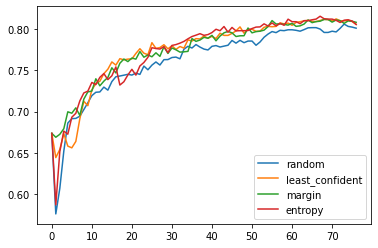

In [95]:
for name, scores in results:
    plt.plot(range(len(scores)), scores, label=(name))
plt.legend(loc="best")
plt.show()